# Import dependencies

In [33]:
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from data_generator import DataGenerator
import numpy as np
import os
import random
import datetime
from train_val_epoch import train_epoch, validation_epoch
from metrics import plot_feature_space, meanf1_iou, plot_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

import os
import random
import numpy as np
import time



# Create Model

In [ ]:
import models

In [6]:
segmentor, \
        domain_clf, \
        reconstruction_model, \
        feature_extractor = models.unet_2d(
                                (256, 256, 12), [16, 32, 32, 64], n_labels=4,
                                stack_num_down=2, stack_num_up=1,
                                activation='GELU', output_activation='Softmax', 
                                batch_norm=True, pool='max', unpool='nearest', siamese=True, name='unet')

# Losses

In [12]:
other = 17749814 + 17766350 + 22149798
corn = 204516 + 172453 + 235173
cotton = 88734 + 26780 + 1677
rice = 10122026 + 6884977 + 7128782
total = other + corn + cotton + rice 

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_other = (1 / other) * (total / 2.0)
weight_for_corn = (1 / corn) * (total / 2.0)
weight_for_cotton = (1 / cotton) * (total / 2.0)
weight_for_rice = (1 / rice) * (total / 2.0)

class_weight = {0: weight_for_other, 1: weight_for_corn, 2: weight_for_cotton, 3: weight_for_rice}

print('Weight for class 0: {:.2f}'.format(weight_for_other))
print('Weight for class 1: {:.2f}'.format(weight_for_corn))
print('Weight for class 2: {:.2f}'.format(weight_for_cotton))
print('Weight for class 3: {:.2f}'.format(weight_for_rice))

weights = [weight_for_other, weight_for_corn, weight_for_cotton, weight_for_rice]

Weight for class 0: 0.72
Weight for class 1: 67.41
Weight for class 2: 352.12
Weight for class 3: 1.71


In [13]:
from losses import distribution_loss, reconstruction_loss, weightedLoss

In [14]:
domain_loss = keras.losses.BinaryCrossentropy()
segmentation_loss=weightedLoss(keras.losses.categorical_crossentropy, weights)
match_distb_loss = distribution_loss()
reconst_loss = reconstruction_loss()

# Create Data Loader

In [17]:
BASE_PATH = "/content/drive/MyDrive/categorical-west/"
TAR_BASE_PATH = "/content/drive/MyDrive/categorical-east/"
NUM_CLASSES = 4
im_height, im_width = 256, 256
test_ratio = 0.1
BATCH_SIZE = 8
NUM_EPOCHS = 50

In [18]:
# Extrac name of files
files = os.listdir(BASE_PATH)
tar_files = os.listdir(TAR_BASE_PATH)
files = [BASE_PATH + f for f in files]
tar_files = [TAR_BASE_PATH + f for f in tar_files]
print("###SRC FILES###")
print(BASE_PATH)
print(len(files))
print("###TAR FILES###")
print(TAR_BASE_PATH)
print(len(tar_files))

###SRC FILES###
/content/drive/MyDrive/categorical-west/
1188
###TAR FILES###
/content/drive/MyDrive/categorical-east/
425


In [20]:
random.seed(10)
random.shuffle(files)
random.shuffle(tar_files)
test_size = int(len(files) * test_ratio)

test_files = files[:test_size]
non_test_files = files[test_size:]

val_size = int(len(non_test_files) * test_ratio)
val_files = non_test_files[:val_size]
train_files = non_test_files[val_size:]

print("Train size:", len(train_files))
print("Validation size:", len(val_files))
print("Test size:", len(test_files))
print(train_files[0])


Train size: 963
Validation size: 107
Test size: 118
/content/drive/MyDrive/categorical-west/1-1_263.npy


In [22]:
maximum, minimum = 14.733826, -49.208305

train_gen = DataGenerator(image_paths=train_files, batch_size=BATCH_SIZE,  augment=True, 
                          shuffle=True, normalize=True, maximum=maximum, minimum=minimum)
val_gen = DataGenerator(image_paths=val_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                        normalize=True, maximum=maximum, minimum=minimum)
test_gen = DataGenerator(image_paths=test_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                         normalize=True, maximum=maximum, minimum=minimum)

tar_gen = DataGenerator(image_paths=tar_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                         normalize=True, maximum=maximum, minimum=minimum)



# Train

In [24]:
segmentor_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
domain_clf_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

reconstruction_model_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
feature_extractor_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
# @tf.function
def train_seg_epoch(x, y):
    y_pred = segmentor(x, training=True)
    seg_loss = segmentation_loss(y, y_pred)
    return seg_loss

# @tf.function
def train_dom_clf_epoch(x_src, x_tar):
    y_src = tf.ones((x_src.shape[0], 1))
    y_tar = tf.zeros((x_tar.shape[0], 1))

    src_dom_pred = domain_clf(x_src, training=True)
    tar_dom_pred = domain_clf(x_tar, training=True)

    src_dom_loss = domain_loss(y_src, src_dom_pred)
    tar_dom_loss = domain_loss(y_tar, tar_dom_pred)

    return src_dom_loss + tar_dom_loss

# @tf.function
def reconstruction_epoch(x):
    xhat = reconstruction_model(x, training=True)
    loss = reconst_loss(x, xhat)

    return loss

# @tf.function
def feature_extractor_epoch(x_src, x_tar):
    src_feature = feature_extractor(x_src, training=True)
    tar_feature = feature_extractor(x_tar, training=True)

    loss = match_distb_loss(src_feature, tar_feature)

    return loss

In [26]:
@tf.function
def train_step(x_src, y_src, x_tar):
    with tf.GradientTape(persistent=True) as tape:
        # train and calculate segmentation loss 
        seg_loss = train_seg_epoch(x_src, y_src)

        # train and calculate domain adaptation part loss
        dom_clf_loss = train_dom_clf_epoch(x_src, x_tar)

        # train and calculate reconstruction loss
        src_reconstruction_loss = reconstruction_epoch(x_src)
        tar_reconstruction_loss = reconstruction_epoch(x_tar)
        total_reconst_loss = src_reconstruction_loss + tar_reconstruction_loss

        # train and calculate feature alignment loss
        feature_alignment_loss = feature_extractor_epoch(x_src, x_tar)

        # total_loss = seg_loss + dom_adapt_loss + src_reconstruction_loss + tar_reconstruction_loss + feature_alignment_loss
    
    # Calculate the gradients for segmentation part
    segmentor_gradients = tape.gradient(seg_loss, 
                                        segmentor.trainable_variables)
    
    # Calculate the gradients for domain classification part
    domain_clf_gradients = tape.gradient(dom_clf_loss,
                                         domain_clf.trainable_variables)
    
    # Calculate the gradients for reconstruction part
    reconstruction_gradients = tape.gradient(total_reconst_loss,
                                             reconstruction_model.trainable_variables)
    
    # Calculate the gradients for feature_extractor part
    feature_extractor_gradients = tape.gradient(feature_alignment_loss,
                                                feature_extractor.trainable_variables)
    
    # Apply the gradients to the optimizer
    segmentor_optimizer.apply_gradients(zip(segmentor_gradients, 
                                            segmentor.trainable_variables))
     
    domain_clf_optimizer.apply_gradients(zip(domain_clf_gradients, 
                                            domain_clf.trainable_variables))
     
    feature_extractor_optimizer.apply_gradients(zip(feature_extractor_gradients, 
                                            feature_extractor.trainable_variables))
     
    reconstruction_model_optimizer.apply_gradients(zip(reconstruction_gradients, 
                                            reconstruction_model.trainable_variables))
    return seg_loss

In [27]:
@tf.function
def validation(x, y):
    pred = segmentor(x)
    loss = segmentation_loss(y, pred)
    
    return loss

In [28]:
checkpoint_path = "drive/MyDrive/siamese-checkpoints/train"

ckpt = tf.train.Checkpoint(segmentor=segmentor,
                           domain_clf=domain_clf,
                           reconstruction_model=reconstruction_model,
                           feature_extractor=feature_extractor,
                           segmentor_optimizer=segmentor_optimizer,
                           domain_clf_optimizer=domain_clf_optimizer,
                           feature_extractor_optimizer=feature_extractor_optimizer,
                           reconstruction_model_optimizer=reconstruction_model_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [29]:
EPOCHS = 100
segmentation_losses = []
val_seg_mean_losses = []
for epoch in range(EPOCHS):
    start = time.time()
    avg_seg_loss = tf.keras.metrics.Mean(name='seg_mean_loss', dtype=None)
    val_avg_seg_loss = tf.keras.metrics.Mean(name='val_seg_mean_loss', dtype=None)
    for i in range(len(train_gen)):
        x_src, y_src = train_gen[i]

        j = i % len(tar_gen)
        x_tar, y_tar = tar_gen[j]

        loss = train_step(x_src, y_src, x_tar)
        avg_seg_loss.update_state(loss)
        if i % 10 == 0:
            print('.', end='')
    train_loss = avg_seg_loss.result().numpy()
    segmentation_losses.append(train_loss)
    print(f"\nSegmentation Train Loss: {train_loss}")

    for x_src, y_src in val_gen:
        val_loss = validation(x_src, y_src)
        val_avg_seg_loss.update_state(val_loss)
    val_seg_mean_losses.append(val_avg_seg_loss.result().numpy())
    print(f"Segmentation Validation Loss: {val_avg_seg_loss.result().numpy()}")

    if (epoch+1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

............
Segmentation Train Loss: 2.073810338973999
Segmentation Validation Loss: 1.8935439586639404
Time taken for epoch 1 is 87.50277352333069 sec

............
Segmentation Train Loss: 1.5290141105651855
Segmentation Validation Loss: 1.2143083810806274
Time taken for epoch 2 is 75.32416987419128 sec

............
Segmentation Train Loss: 1.3207640647888184
Segmentation Validation Loss: 1.4024910926818848
Time taken for epoch 3 is 76.02109861373901 sec

............
Segmentation Train Loss: 1.2740559577941895
Segmentation Validation Loss: 1.302194595336914
Time taken for epoch 4 is 76.61800789833069 sec

............
Segmentation Train Loss: 1.1962641477584839
Segmentation Validation Loss: 1.2206685543060303
Saving checkpoint for epoch 5 at drive/MyDrive/siamese-checkpoints/train/ckpt-1
Time taken for epoch 5 is 77.71582841873169 sec

............
Segmentation Train Loss: 1.1596347093582153
Segmentation Validation Loss: 1.0838571786880493
Time taken for epoch 6 is 76.479868173599

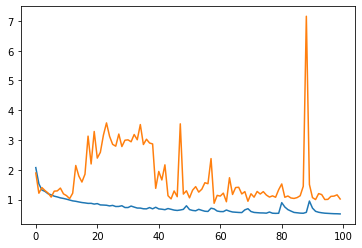

In [34]:
plt.plot(segmentation_losses, label="train loss")
plt.plot(val_seg_mean_losses, label='validation loss')